In [1]:


##############################################################################
# 1) INSTALL DEPENDENCIES
##############################################################################
!pip install faiss-cpu sentence-transformers scikit-learn matplotlib seaborn transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 19.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 15.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 8.5 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import json
import re
import textwrap
import torch
import faiss
import numpy as np
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1740351704.485585      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [7]:
##############################################################################
# 1) CONFIGURATION
##############################################################################
# Model Config
MODEL_NAME = "deepseek-ai/deepseek-llm-7b-chat"
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# LoRA Config
LORA_RANK = 8
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
TARGET_MODULES = ["q_proj", "v_proj"]

# Training Config
BATCH_SIZE = 2
ACCUMULATION_STEPS = 4
LEARNING_RATE = 3e-5
MAX_GRAD_NORM = 0.3
FEEDBACK_BUFFER_SIZE = 3  # Lowered for demo purposes

# Quantization Config
#BNB_CONFIG = BitsAndBytesConfig(
    #load_in_4bit=True,
    #bnb_4bit_use_double_quant=True,
    #bnb_4bit_quant_type="nf4",
   # bnb_4bit_compute_dtype=torch.float16
#)

In [8]:
##############################################################################
# 2) INITIALIZE MODELS
##############################################################################
# Initialize embedding model
embed_model = SentenceTransformer(EMBED_MODEL)

# Initialize LLM with QLoRA
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
   # quantization_config=BNB_CONFIG,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder="offload"

)

# Prepare model for PEFT
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    target_modules=TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Set pad token
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


trainable params: 3,932,160 || all params: 6,914,297,856 || trainable%: 0.0569


In [11]:
##############################################################################
# 3) DATA MANAGEMENT
##############################################################################
class FeedbackManager:
    def __init__(self, filename="feedback_dataset.json"):
        self.filename = filename
        self.data = {"examples": []}
        self.load_existing()
    
    def load_existing(self):
        try:
            with open(self.filename, "r") as f:
                self.data = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            self.data = {"examples": []}
    
    def add_example(self, query, context, correction):
        self.data["examples"].append({
            "input": f"CONTEXT: {context}\nQUERY: {query}",
            "output": correction
        })
        self.save()
    
    def save(self):
        with open(self.filename, "w") as f:
            json.dump(self.data, f, indent=2)
    
    def clear_buffer(self):
        self.data["examples"] = []
        self.save()

feedback_manager = FeedbackManager()

In [12]:
##############################################################################
# 4) TRAINING SETUP
##############################################################################
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./lora_adapters",
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    max_grad_norm=MAX_GRAD_NORM,
    logging_steps=5,
    remove_unused_columns=True,
    report_to="none"
)

def perform_online_tuning():
    if len(feedback_manager.data["examples"]) < BATCH_SIZE:
        return False

    try:
        formatted_data = []
        for example in feedback_manager.data["examples"]:
            encoded = tokenizer(
                example["input"] + "\nANSWER: " + example["output"],
                max_length=512,
                padding="max_length",
                truncation=True
            )
            formatted_data.append({
                "input_ids": encoded["input_ids"],
                "attention_mask": encoded["attention_mask"],
                "labels": encoded["input_ids"].copy()
            })

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=formatted_data,
            data_collator=data_collator
        )
        trainer.train()
        model.save_pretrained("./lora_adapters")
        return True
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return False

E0000 00:00:1740352256.689583      10 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:239


In [13]:
##############################################################################
# 5) RAG PIPELINE
##############################################################################
# Document Knowledge Base
documents = [
    {
        "id": "best_practice",
        "text": """Best practice color guide:
- Bedroom parents – Brown
- Bedroom girls – Pink
- Bedroom boy – Blue
- Bathroom – White
- Living room – Beige"""
    },
    {
        "id": "house1",
        "text": """House 1:
- Bedroom parents – Black
- Bedroom girl – Yellow
- Bathroom – Green
- Living room – Beige"""
    },
    {
        "id": "house2",
        "text": """House 2:
- Bedroom parents – Brown
- Bedroom girls – Pink
- Bedroom boy – Blue
- Bathroom – Green
- Living room – Beige"""
    }
]

In [14]:
# Build FAISS Index
texts = [doc["text"] for doc in documents]
embeddings = embed_model.encode(texts, convert_to_numpy=True)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

def retrieve_documents(query, top_k=2):
    query_embed = embed_model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embed, top_k)
    return [documents[i] for i in indices[0]]

def generate_response(query, context):
    prompt = f"""Analyze this context and answer the question. Follow these rules:
1. Be factual and precise
2. If unsure, say "I don't know"
3. Never invent information

CONTEXT: {context}

QUESTION: {query}
ANSWER: """
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.7,
        repetition_penalty=1.1,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("ANSWER:")[-1].strip()


=== RAG Chatbot with Continuous Learning ===
Type 'exit' to quit




Your question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly



ANSWER: Based on the provided best practice color guide, House 1 has not followed it accurately in some instances. The correct colors for a bedroom parent should be brown, while black is used instead. Similarly, yellow is an incorrect choice for a bedroom girl according to the guidelines provided. The bathroom of House 1 is painted with green which also does not match any of the prescribed colors from the given guide. However, beige remains consistent as per the suggested living room paint color.

In contrast, House 2 appears to follow the recommended color scheme quite closely overall, aside from one inconsistency. Although white was mentioned as the appropriate color for bathrooms, blue would still work since there are no specific instructions against using that shade. Other than this minor deviation, House 2 largely adheres to the ideal color choices outlined by the best practice guide.



Was this answer correct? (y/n):  y

Your question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly



ANSWER: Based on the best practice color guide provided, House 1 has not been painted according to the recommended colors for each room in a home. For example, it is suggested that bedroom parents be painted brown, but instead, they are painted black. Similarly, the bathroom should be white, but it is painted green. The living room should ideally feature beige paint, which also contrasts with the other rooms. On the other hand, House 2 appears to follow the best practice color guide accurately, as all of its assigned colors match the expected ones from the guide. Therefore, I would recommend repainting House 1 using the guidelines presented.



Was this answer correct? (y/n):  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly

Your question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly



ANSWER: Based on the provided best practice color guide for each room, House 1 has not followed some of the recommended colors. For example, the bedroom parent is black instead of brown (which would be a better fit), and yellow instead of pink for the bedroom girl. The bathroom is green instead of white, which goes against the best practice. However, the living room remains consistent with beige, following the suggested shade.

In comparison, House 2 follows most of the recommendations in the best practice color guide, except for one minor deviation - the use of pink as opposed to blue for the bedroom boy. Despite that variation, it largely adheres to the guidelines set forth by the color guide.



Was this answer correct? (y/n):  y

Your question:  exit



=== Final Evaluation ===


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



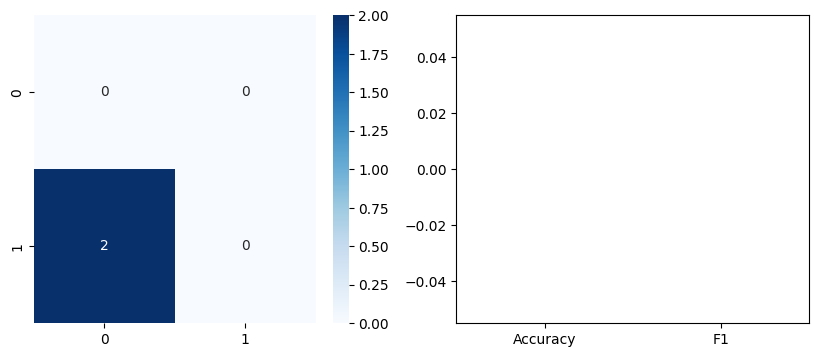

In [15]:
##############################################################################
# 6) INTERACTIVE DEMO
##############################################################################
def validate_feedback(answer):
    answer_lower = answer.lower()
    positive = ['correct', 'yes', 'proper', 'matches']
    negative = ['incorrect', 'no', 'wrong', 'mismatch']
    return 1 if sum(p in answer_lower for p in positive) > sum(n in answer_lower for n in negative) else 0

def run_demo():
    y_true = []
    y_pred = []
    session_feedback = 0
    
    print("\n=== RAG Chatbot with Continuous Learning ===")
    print("Type 'exit' to quit\n")
    
    while True:
        try:
            query = input("\nYour question: ").strip()
            if query.lower() in ['exit', 'quit']:
                break
            
            # Retrieve context
            docs = retrieve_documents(query)
            context = "\n".join(d["text"] for d in docs)
            
            # Generate answer
            answer = generate_response(query, context)
            print(f"\nANSWER: {answer}")
            
            # Get feedback
            feedback = input("\nWas this answer correct? (y/n): ").lower()
            if feedback == 'y':
                y_true.append(1)
                y_pred.append(validate_feedback(answer))
            elif feedback == 'n':
                correction = input("Provide the correct answer: ")
                feedback_manager.add_example(query, context, correction)
                session_feedback += 1
                y_true.append(0)
                y_pred.append(validate_feedback(answer))
                
                if session_feedback >= FEEDBACK_BUFFER_SIZE:
                    print("\nUpdating model with new feedback...")
                    if perform_online_tuning():
                        print("Model updated successfully!")
                        session_feedback = 0
                    else:
                        print("Update failed - continuing with current model")
            
            # Periodic evaluation
            if len(y_true) % 3 == 0 and len(y_true) > 0:
                print("\n=== Current Performance ===")
                print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
                print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.2f}")
                
        except KeyboardInterrupt:
            print("\nSession ended by user")
            break

    # Final evaluation
    if y_true:
        print("\n=== Final Evaluation ===")
        print(classification_report(y_true, y_pred))
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.subplot(1, 2, 2)
        sns.barplot(x=['Accuracy', 'F1'], y=[accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)])
        plt.show()

if __name__ == "__main__":
    run_demo()